Utilizando "Random Forest" para detectar anomalias.

Kaggle dataset: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from category_encoders.one_hot import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict, train_test_split

In [194]:
data = pd.read_csv('dataset/fake_job_postings.csv')
#data.head(4)
data.salary_range.unique()

array([nan, '20000-28000', '100000-120000', '120000-150000',
       '50000-65000', '40000-50000', '60-80', '65000-70000', '75-115',
       '75000-110000', '17000-20000', '16000-28000', '95000-115000',
       '15000-18000', '50000-70000', '45000-60000', '30000-40000',
       '70000-90000', '10000-14000', '50-110', '28000-45000', '0-34300',
       '35000-40000', '9-Dec', '44000-57000', '18500-28000',
       '55000-75000', '30000-35000', '0-0', '20000-40000',
       '360000-600000', '50000-80000', '80000-100000', '52000-78000',
       '15750-15750', '40000-65000', '45000-50000', '30000-37000',
       '45000-67000', '35000-100000', '180000-216000', '45000-65000',
       '28000-32000', '0-1000', '36000-40000', '80000-110000',
       '35000-73000', '19000-19000', '60000-120000', '120000-15000000',
       '42000-55000', '90000-120000', '100000-150000', '28000-38000',
       '1600-1700', '50000-60000', '30000-70000', '32000-40000', '50-100',
       '9000-17000', '23040-28800', '105-110', '1300

In [182]:
#target: valor que queremos prever
y = data["fraudulent"]

# Remover o target do dataset 
# axis 1 refers to the columns
X = data.drop('fraudulent', axis = 1)

#variáveis categóricas: verificar quais
#levando em consideração ter no máximo 40 valores diferentes
categorical_columns = []
not_categorical_columns = []
for col in X.columns:
    print(f'Valores únicos na coluna {col}:', data[col].nunique())
    if (data[col].nunique() < 38):
        categorical_columns.append(col)
    else:
        not_categorical_columns.append(col)

print('Not categorical columns:', len(not_categorical_columns), not_categorical_columns)
print('Categorical columns: ', len(categorical_columns) , categorical_columns)


Valores únicos na coluna job_id: 17880
Valores únicos na coluna title: 11231
Valores únicos na coluna location: 3105
Valores únicos na coluna department: 1337
Valores únicos na coluna salary_range: 874
Valores únicos na coluna company_profile: 1709
Valores únicos na coluna description: 14801
Valores únicos na coluna requirements: 11968
Valores únicos na coluna benefits: 6205
Valores únicos na coluna telecommuting: 2
Valores únicos na coluna has_company_logo: 2
Valores únicos na coluna has_questions: 2
Valores únicos na coluna employment_type: 5
Valores únicos na coluna required_experience: 7
Valores únicos na coluna required_education: 13
Valores únicos na coluna industry: 131
Valores únicos na coluna function: 37
Not categorical columns: 10 ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'industry']
Categorical columns:  7 ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_expe

In [183]:
#retirar as colunas não categóricas
X = X.drop(not_categorical_columns, axis=1)
print(X.dtypes, '\n\n', X.isnull().sum())

telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
function               object
dtype: object 

 telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
function               6455
dtype: int64


In [184]:
#tratar dados nulos
coluns_change_nan = {'employment_type': '', 'required_experience': '', 'required_education': '', 'function': ''}
X = X.fillna(value=coluns_change_nan)
X

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function
0,0,1,0,Other,Internship,,Marketing
1,0,1,0,Full-time,Not Applicable,,Customer Service
2,0,1,0,,,,
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Sales
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Health Care Provider
...,...,...,...,...,...,...,...
17875,0,1,1,Full-time,Mid-Senior level,,Sales
17876,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Accounting/Auditing
17877,0,0,0,Full-time,,,
17878,0,0,1,Contract,Not Applicable,Professional,Design


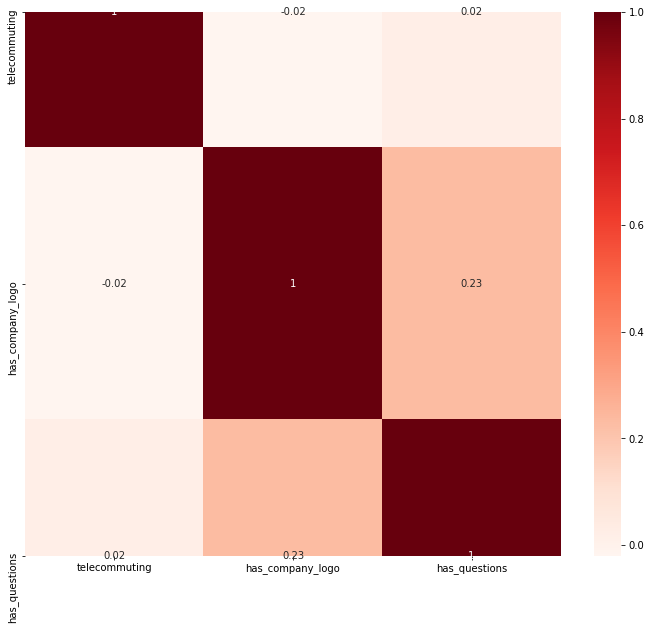

In [185]:
%matplotlib inline
#Apresentando visualmente as correlações
#corr = df_train[features_corr].corr()
corr = X.corr()
gr = plt.subplots(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='Reds')

In [186]:
#transformar as variáveis categóricas utilizando a biblioteca "category_encoders"
enc = OneHotEncoder(cols=categorical_columns, use_cat_names=True)

enc.fit(X)
X = enc.transform(X)
X

,telecommuting_0.0,telecommuting_1.0,has_company_logo_1.0,has_company_logo_0.0,has_questions_0.0,has_questions_1.0,employment_type_Other,employment_type_Full-time,employment_type_,employment_type_Part-time,...,function_Art/Creative,function_Quality Assurance,function_Data Analyst,function_Business Analyst,function_Writing/Editing,function_Distribution,function_Science,function_Training,function_Purchasing,function_Legal
0,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17876,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17877,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17878,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
#separar dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42)
X_train

,telecommuting_0.0,telecommuting_1.0,has_company_logo_1.0,has_company_logo_0.0,has_questions_0.0,has_questions_1.0,employment_type_Other,employment_type_Full-time,employment_type_,employment_type_Part-time,...,function_Art/Creative,function_Quality Assurance,function_Data Analyst,function_Business Analyst,function_Writing/Editing,function_Distribution,function_Science,function_Training,function_Purchasing,function_Legal
16831,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13443,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3548,0,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15950,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12055,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
11964,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5390,1,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
860,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
def rfr_model(X, y):
    
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (50, 100),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=6)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], 
                                n_estimators=best_params["n_estimators"], 
                                random_state=False, verbose=False)
    
    return rfr

In [160]:
rfr = rfr_model(X_train, y_train)

In [164]:
# Perform K-Fold CV
scores = cross_val_score(rfr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

# get the list of values predicted using the model
#predictions = cross_val_predict(rfr, X_train, y_train, cv=10)

In [165]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores.mean())
print(scores)
#print(predictions)

Accuracy: -0.07 (+/- 0.01)
-0.07029190283236836
[-0.07224633 -0.07073851 -0.06639969 -0.06887319 -0.06481843 -0.0722741
 -0.0664999  -0.07753052 -0.07224435 -0.07129403]
